Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'returnsWharton_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01         -0.001543          0.000458                -0.002399   
1     2006-06-02          0.013251          0.003315                 0.003719   
2     2006-06-05         -0.000486         -0.002491                 0.001635   
3     2006-06-06         -0.022796         -0.010474                -0.010117   
4     2006-06-07         -0.020042         -0.004991                -0.007670   
...          ...               ...               ...                      ...   
4918  2025-05-26          0.004288          0.000899                 0.002356   
4919  2025-05-27          0.000655          0.000359                -0.001818   
4920  2025-05-28          0.000465          0.001329                 0.002046   
4921  2025-05-29          0.007431          0.001169                 0.000911   
4922  2025-05-30          0.001591          0.003514                 0.001879

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01         -0.001543          0.000458                -0.002399   
1  2006-06-02          0.013251          0.003315                 0.003719   
2  2006-06-05         -0.000486         -0.002491                 0.001635   
3  2006-06-06         -0.022796         -0.010474                -0.010117   
4  2006-06-07         -0.020042         -0.004991                -0.007670   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.000151                -0.001090  0.000261  0.003190  
1            0.014317                 0.011289  0.008206  0.025093  
2           -0.001778                -0.000659 -0.002297 -0.004045  
3           -0.022318                -0.018675 -0.014682 -0.032709  
4           -0.017413                -0.016592 -0.010775 -0.020330

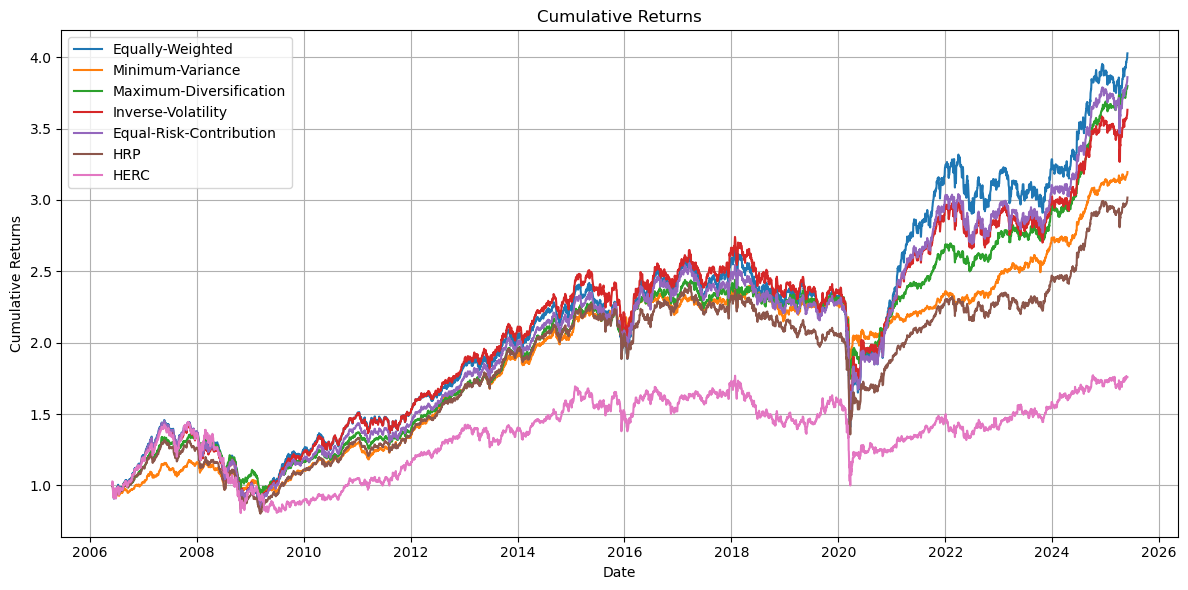

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
letzte_returns = kumulative_returns.iloc[-1]
print(letzte_returns)

Equally-Weighted           4.026764
Minimum-Variance           3.195279
Maximum-Diversification    3.798031
Inverse-Volatility         3.631359
Equal-Risk-Contribution    3.859771
HRP                        3.016533
HERC                       1.758104
Name: 2025-05-30 00:00:00, dtype: float64


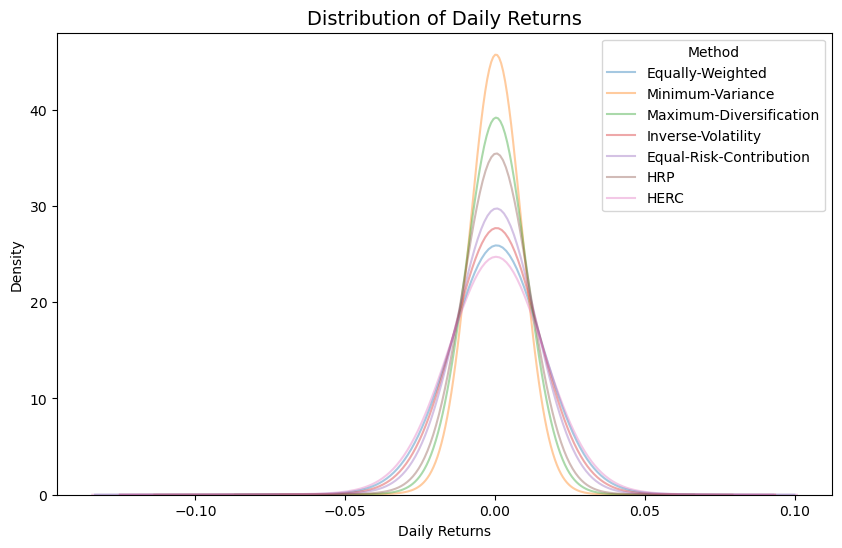

In [22]:
plt.figure(figsize=(10, 6))
for col in df_SP500.columns:
    sb.kdeplot(df_SP500[col], label=col, fill=False, alpha=0.4, bw_adjust=9)

plt.title("Distribution of Daily Returns", fontsize=14)
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend(title="Method")
plt.show()

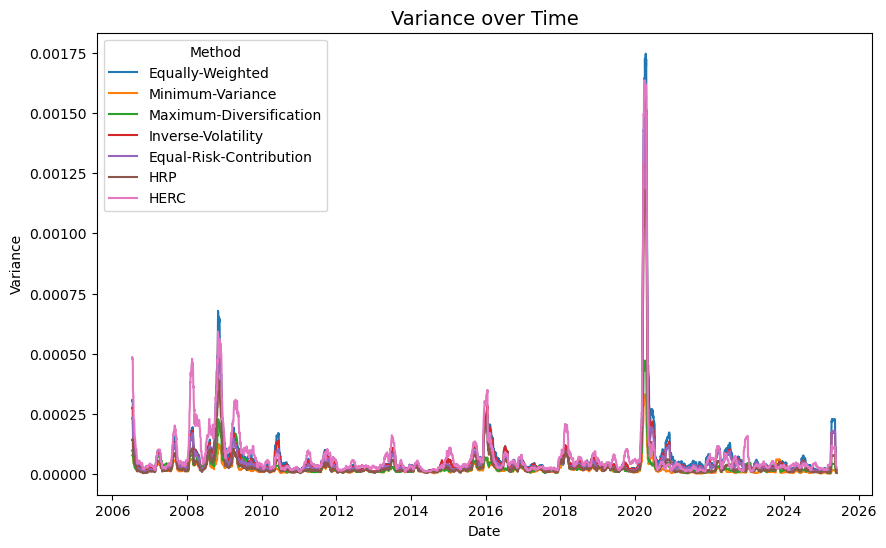

In [23]:
rollierende_varianz = df_SP500.rolling(window=30).var()

plt.figure(figsize=(10, 6))
for col in rollierende_varianz.columns:
    plt.plot(rollierende_varianz.index, rollierende_varianz[col], label=col)

plt.title("Variance over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend(title="Method")
plt.show()

In [24]:
#Letzten Wert jedes Jahres extrahieren
df_kum_endwerte = kumulative_returns.resample('Y').last()

#Jahr als Spalte
df_kum_endwerte.index = df_kum_endwerte.index.year
df_kum_endwerte.index.name = "Year"

df_kum_endwerte.head()

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          1.209794          1.023082                 1.128801   
2007          1.376217          1.162729                 1.353731   
2008          0.993151          1.012347                 1.077265   
2009          1.253721          1.107960                 1.170954   
2010          1.499359          1.292882                 1.367691   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            1.195938                 1.197085  1.126315  1.190944  
2007            1.348183                 1.378565  1.263881  1.355717  
2008            0.996797                 0.990505  0.930994  0.962422  
2009            1.234734                 1.190021  1.109639  0.894384  
2010            1.496076                 1.426863  1.324878  1.049058

In [25]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

#Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Year"

jährlich_kum_returns.head()

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          0.209794          0.023082                 0.128801   
2007          0.137563          0.136497                 0.199264   
2008         -0.278347         -0.129336                -0.204225   
2009          0.262367          0.094447                 0.086969   
2010          0.195927          0.166904                 0.168014   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            0.195938                 0.197085  0.126315  0.190944  
2007            0.127302                 0.151601  0.122138  0.138355  
2008           -0.260637                -0.281495 -0.263385 -0.290101  
2009            0.238702                 0.201429  0.191887 -0.070695  
2010            0.211659                 0.199023  0.193972  0.172940

In [26]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [27]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Year", var_name="Strategy", value_name="Returns")
reorganisiert.head()

Year          Strategy   Returns
0  2006  Equally-Weighted  0.209794
1  2007  Equally-Weighted  0.137563
2  2008  Equally-Weighted -0.278347
3  2009  Equally-Weighted  0.262367
4  2010  Equally-Weighted  0.195927

In [28]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Year", y="Returns", color="Strategy", 
             barmode="group",
             text="Returns",
             title="Yearly Cumulative Returns",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [29]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

print(jährliche_vola.round(2))

      Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006             14.74              8.32                     9.26   
2007             11.59              8.00                    10.10   
2008             21.00             11.38                    13.84   
2009             14.14              8.92                    11.46   
2010             10.59              5.56                     6.57   
2011             11.04              6.50                     7.01   
2012              7.30              5.64                     5.85   
2013              9.80              6.02                     6.24   
2014              8.32              6.14                     6.62   
2015             12.78              7.87                     8.60   
2016             14.03              7.65                     8.33   
2017              8.62              5.75                     6.63   
2018             11.51            

<Figure size 1000x600 with 0 Axes>

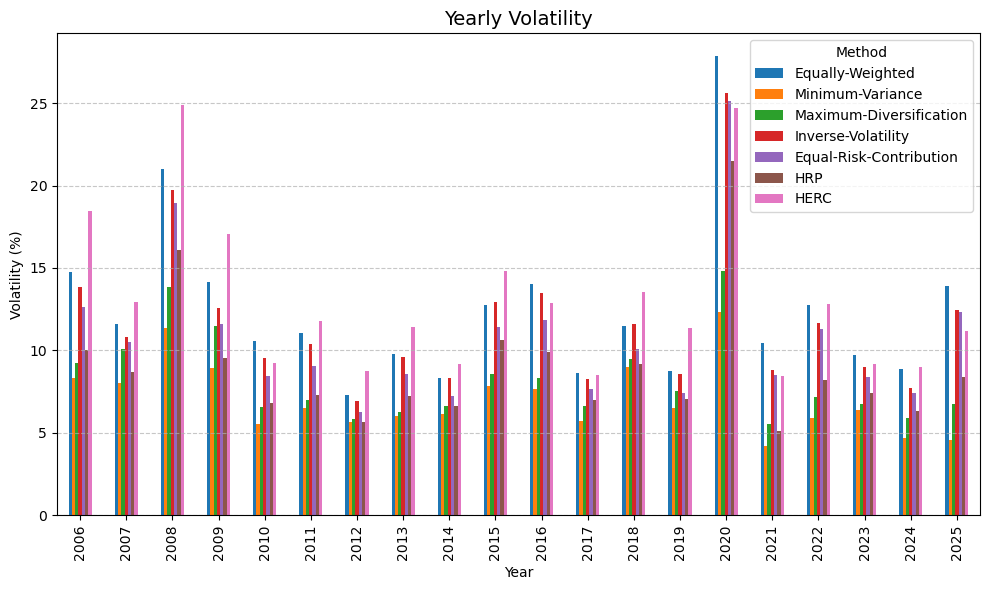

In [30]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Yearly Volatility", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Volatility (%)")
plt.legend(title="Method")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [31]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [32]:
sharpe_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.297906          0.513370                 2.298005   
2007          1.181876          1.656731                 1.868843   
2008         -1.456484         -1.166842                -1.590489   
2009          1.702566          1.046808                 0.777949   
2010          1.694015          2.726373                 2.329516   
2011          0.108217          0.555584                 0.189986   
2012          2.636254          3.915000                 3.234908   
2013          1.142345          2.129433                 2.352702   
2014          1.165740          1.165587                 1.147112   
2015         -0.610597          0.713681                 0.027681   
2016          1.277918          0.532040                 1.282736   
2017          0.627839          0.614110                 0.299647   
20

In [33]:
#Durchschnitt
sharpe_durchschnitt = sharpe_jahresweise.mean(axis=1)

sharpe_durchschnitt = sharpe_durchschnitt.to_frame(name="Sharpe_Mittelwert")

sharpe_durchschnitt.info

<bound method DataFrame.info of       Sharpe_Mittelwert
Date                   
2006           1.961643
2007           1.392553
2008          -1.486096
2009           1.204658
2010           2.166876
2011           0.306779
2012           3.119389
2013           1.508312
2014           1.219979
2015          -0.136905
2016           0.985763
2017           0.556533
2018          -0.871938
2019           0.217980
2020          -0.228856
2021           3.059898
2022          -0.060105
2023           1.101448
2024           2.433426
2025           0.584128>

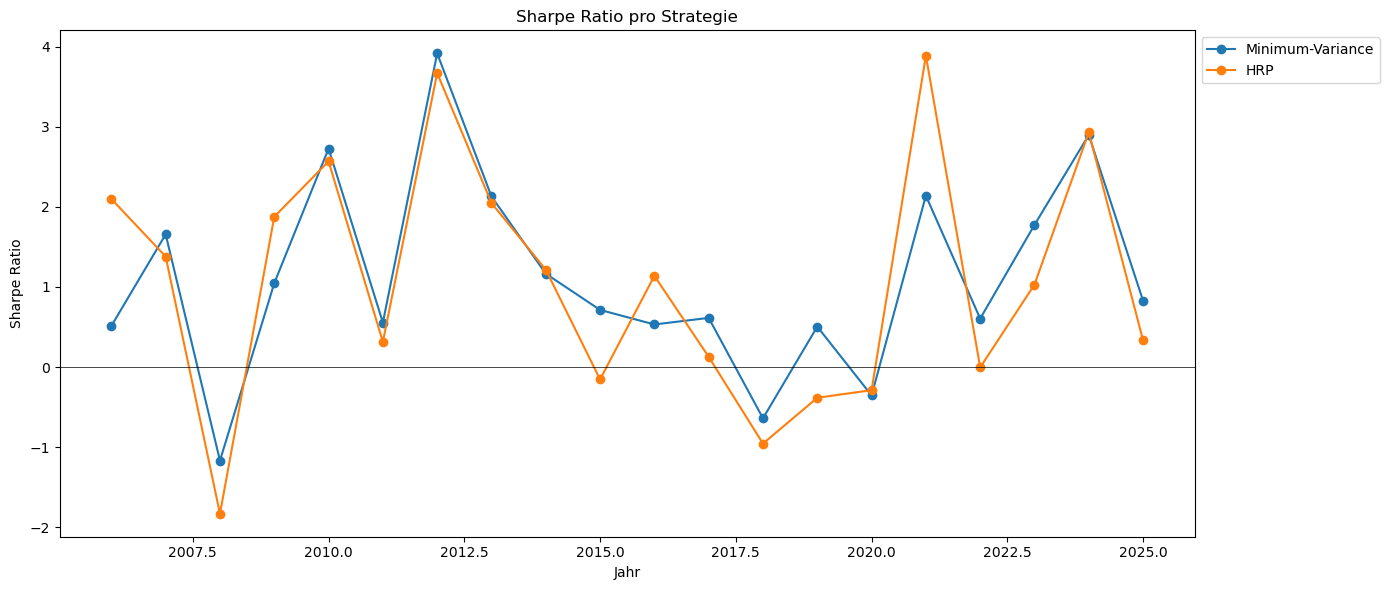

In [34]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

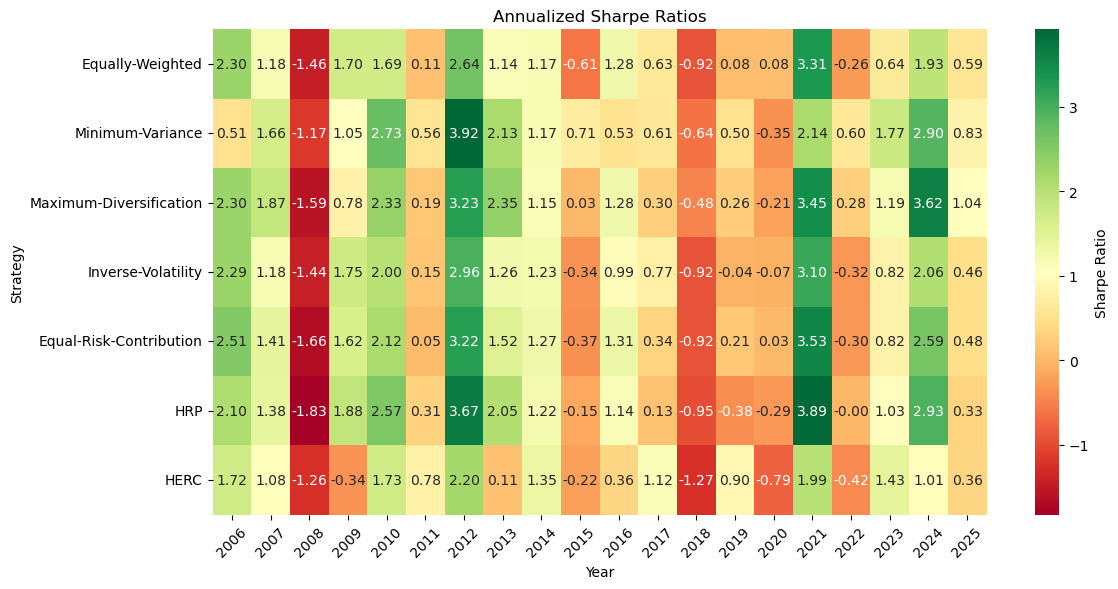

In [35]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005       
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [37]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annualized_sharpe = df_SP500.apply(sharpe_annual)

print(annualized_sharpe)

Equally-Weighted           0.607738
Minimum-Variance           0.840102
Maximum-Diversification    0.834610
Inverse-Volatility         0.598055
Equal-Risk-Contribution    0.658045
HRP                        0.631525
HERC                       0.278794
dtype: float64


In [38]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_total(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4910)  #4780 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
total_sharpe = df_SP500.apply(sharpe_total)

print(total_sharpe)

Equally-Weighted           2.682605
Minimum-Variance           3.708281
Maximum-Diversification    3.684038
Inverse-Volatility         2.639862
Equal-Risk-Contribution    2.904666
HRP                        2.787605
HERC                       1.230622
dtype: float64


#### Sortino

In [39]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [40]:
sortino_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.077641          0.641896                 3.073185   
2007          1.603521          2.457960                 2.749594   
2008         -1.849933         -1.496759                -1.979383   
2009          2.545972          1.504681                 1.206756   
2010          2.496570          4.337268                 3.633736   
2011          0.147476          0.801727                 0.265640   
2012          4.046631          7.306024                 5.573979   
2013          1.581059          3.121691                 3.478554   
2014          1.721982          1.663540                 1.679807   
2015         -0.785512          0.996964                 0.037341   
2016          1.920777          0.785130                 1.940628   
2017          0.932885          0.915326                 0.430544   
20

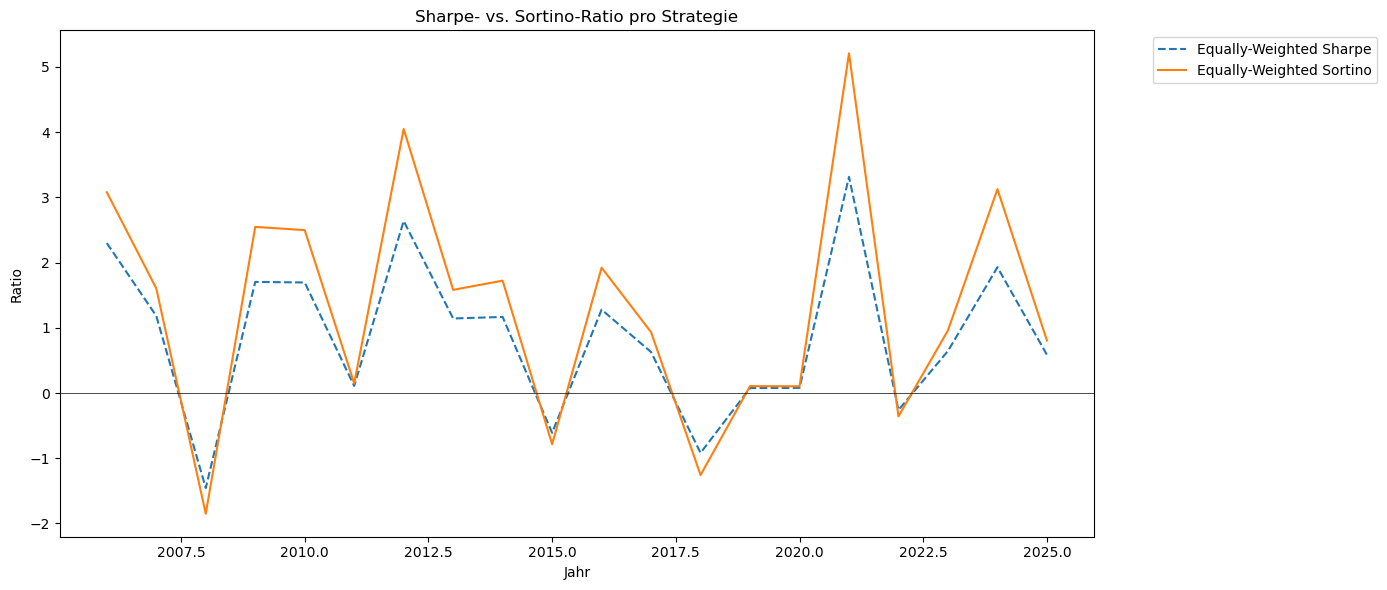

In [41]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino = df_SP500.apply(sortino_annual)

print(annualized_sortino)

Equally-Weighted           0.836233
Minimum-Variance           1.185240
Maximum-Diversification    1.176354
Inverse-Volatility         0.819787
Equal-Risk-Contribution    0.897619
HRP                        0.851701
HERC                       0.380286
dtype: float64


In [43]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4910)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_total)

print(gesamt_sortino)

Equally-Weighted           3.691202
Minimum-Variance           5.231749
Maximum-Diversification    5.192524
Inverse-Volatility         3.618606
Equal-Risk-Contribution    3.962164
HRP                        3.759480
HERC                       1.678613
dtype: float64


#### Maximum Drawdown

In [44]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [45]:
max_drawdown_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.103348         -0.087658                -0.065653   
2007         -0.141497         -0.082531                -0.095292   
2008         -0.373133         -0.222294                -0.289022   
2009         -0.185958         -0.113885                -0.180008   
2010         -0.086979         -0.032128                -0.056172   
2011         -0.100825         -0.092256                -0.082431   
2012         -0.038322         -0.019043                -0.016682   
2013         -0.068380         -0.057649                -0.048467   
2014         -0.071786         -0.051066                -0.067206   
2015         -0.218059         -0.097318                -0.127654   
2016         -0.086474         -0.063776                -0.049978   
2017         -0.115091         -0.055246                -0.081791   
20

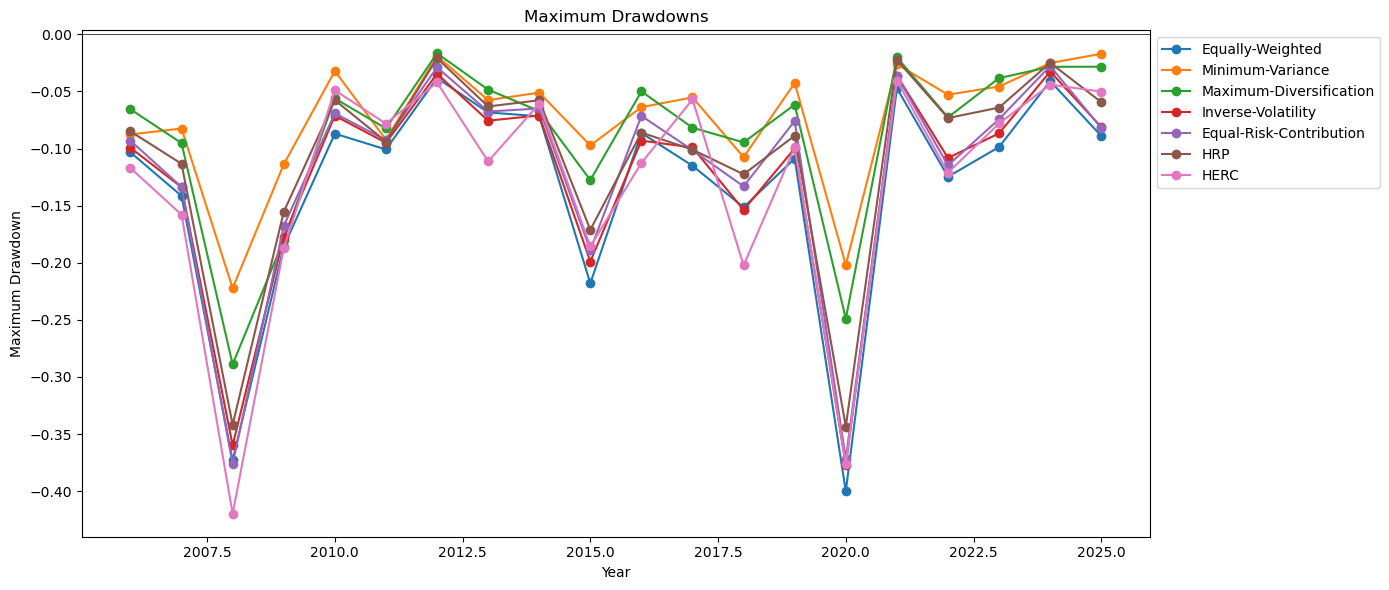

In [46]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Year")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdowns")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.470674
Minimum-Variance          -0.239625
Maximum-Diversification   -0.329254
Inverse-Volatility        -0.457726
Equal-Risk-Contribution   -0.430919
HRP                       -0.437334
HERC                      -0.441769
dtype: float64>

#### Calmar Ratio

In [48]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio))

In [49]:
calmar_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.735800          0.455112                 3.516063   
2007          0.980493          1.667991                 2.109399   
2008         -0.748485         -0.583984                -0.709112   
2009          1.392313          0.819123                 0.477217   
2010          2.177087          5.022844                 2.891966   
2011          0.058152          0.374239                 0.132273   
2012          5.440724         12.834400                12.326286   
2013          1.650659          2.330672                 3.208647   
2014          1.362109          1.410176                 1.136310   
2015         -0.378281          0.558563                -0.010281   
2016          2.130655          0.602347                 2.174649   
2017          0.448500          0.617962                 0.217700   
20

In [50]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.157024
Minimum-Variance           0.255682
Maximum-Diversification    0.214719
Inverse-Volatility         0.149086
Equal-Risk-Contribution    0.166113
HRP                        0.132954
HERC                       0.066332
dtype: float64>

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           6.430698
Minimum-Variance           9.161310
Maximum-Diversification    8.498085
Inverse-Volatility         5.748759
Equal-Risk-Contribution    6.636453
HRP                        4.610971
HERC                       1.716063
dtype: float64>

#### Value at Risk

In [52]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.016121         -0.009441                -0.008118   
2007         -0.011691         -0.007075                -0.008821   
2008         -0.024118         -0.012932                -0.017189   
2009         -0.015467         -0.008792                -0.009578   
2010         -0.010488         -0.005282                -0.006936   
2011         -0.012052         -0.006732                -0.007212   
2012         -0.006959         -0.004706                -0.005025   
2013         -0.010717         -0.005607                -0.005937   
2014         -0.008105         -0.006257                -0.006394   
2015         -0.014700         -0.007076                -0.008290   
2016         -0.014320         -0.007146                -0.009005   
2017         -0.007818         -0.005400                -0.006398   
20

In [53]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.012399
Minimum-Variance          -0.006750
Maximum-Diversification   -0.007931
Inverse-Volatility        -0.011523
Equal-Risk-Contribution   -0.010480
HRP                       -0.008574
HERC                      -0.012781
dtype: float64>

In [54]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.047461
Minimum-Variance          -0.032522
Maximum-Diversification   -0.030100
Inverse-Volatility        -0.042143
Equal-Risk-Contribution   -0.040843
HRP                       -0.039956
HERC                      -0.051816
dtype: float64>

#### Expected Shortfall

In [55]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.024985         -0.015205                -0.014898   
2007         -0.018759         -0.011074                -0.014556   
2008         -0.033490         -0.017858                -0.022423   
2009         -0.018244         -0.012348                -0.013911   
2010         -0.014569         -0.007360                -0.008750   
2011         -0.015852         -0.008888                -0.009662   
2012         -0.009976         -0.005969                -0.006635   
2013         -0.014885         -0.008601                -0.008452   
2014         -0.011782         -0.008853                -0.008776   
2015         -0.019982         -0.011111                -0.012913   
2016         -0.019115         -0.009804                -0.010866   
2017         -0.011415         -0.007227                -0.009361   
20

In [56]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.019770
Minimum-Variance          -0.010869
Maximum-Diversification   -0.012488
Inverse-Volatility        -0.018567
Equal-Risk-Contribution   -0.017412
HRP                       -0.014701
HERC                      -0.020984
dtype: float64>

In [57]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.092746
Minimum-Variance          -0.055527
Maximum-Diversification   -0.065140
Inverse-Volatility        -0.086310
Equal-Risk-Contribution   -0.087593
HRP                       -0.081648
HERC                      -0.088575
dtype: float64>

In [58]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.278347
Minimum-Variance          -0.129336
Maximum-Diversification   -0.204225
Inverse-Volatility        -0.260637
Equal-Risk-Contribution   -0.281495
HRP                       -0.263385
HERC                      -0.290101
dtype: float64>

In [59]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([annualized_sharpe, annualized_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.607738  0.836233     -0.470674  6.430698 -0.047461   
Minimum-Variance         0.840102  1.185240     -0.239625  9.161310 -0.032522   
Maximum-Diversification  0.834610  1.176354     -0.329254  8.498085 -0.030100   
Inverse-Volatility       0.598055  0.819787     -0.457726  5.748759 -0.042143   
Equal-Risk-Contribution  0.658045  0.897619     -0.430919  6.636453 -0.040843   
HRP                      0.631525  0.851701     -0.437334  4.610971 -0.039956   
HERC                     0.278794  0.380286     -0.441769  1.716063 -0.051816   

                               ES  
Equally-Weighted        -0.092746  
Minimum-Variance        -0.055527  
Maximum-Diversification -0.065140  
Inverse-Volatility      -0.086310  
Equal-Risk-Contribution -0.087593  
HRP                     -0.081648  
HERC                    -0.088575  


## S&P 500 mit Ledoit-Shrinkage

In [60]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnsWhartonshrinked_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [61]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01         -0.001543         -0.000304                -0.002005   
1     2006-06-02          0.013251          0.005923                 0.004621   
2     2006-06-05         -0.000486         -0.001452                 0.000932   
3     2006-06-06         -0.022796         -0.011150                -0.010846   
4     2006-06-07         -0.020042         -0.008046                -0.011165   
...          ...               ...               ...                      ...   
4918  2025-05-26          0.004288          0.001469                 0.002057   
4919  2025-05-27          0.000655          0.000055                -0.002212   
4920  2025-05-28          0.000465          0.002203                 0.002387   
4921  2025-05-29          0.007431          0.001654                 0.002094   
4922  2025-05-30          0.001591          0.002633                 0.000904

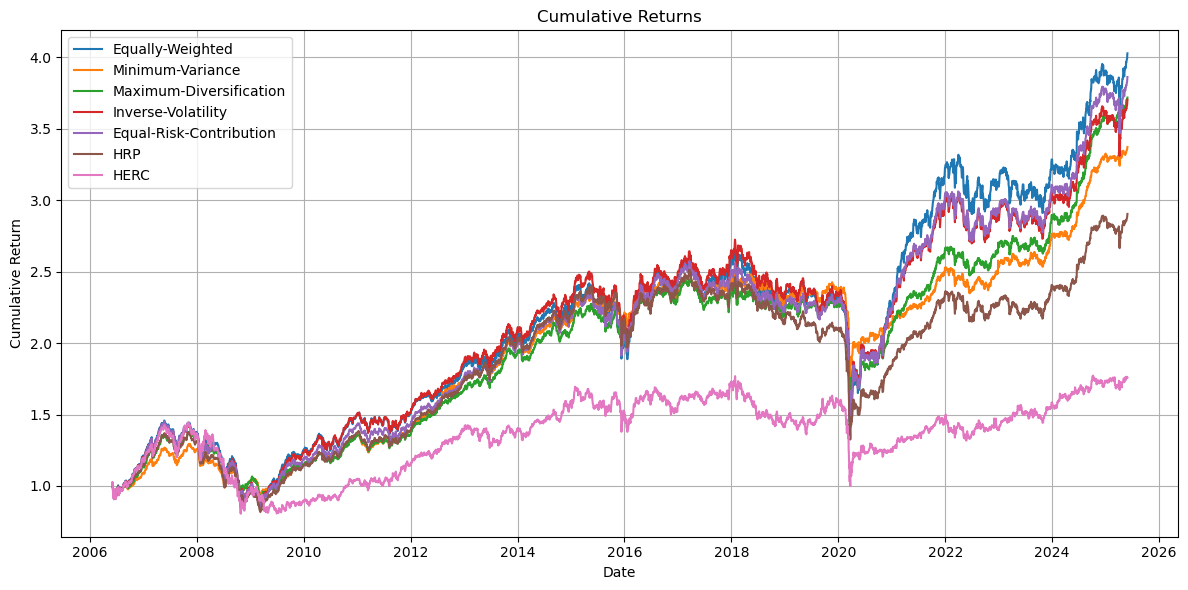

In [62]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [64]:
sharpe_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.297906          1.708361                 2.333720   
2007          1.181876          1.767286                 1.860743   
2008         -1.456484         -1.631662                -1.819122   
2009          1.702566          1.273980                 0.981100   
2010          1.694015          2.795594                 2.358693   
2011          0.108217          0.381151                 0.109728   
2012          2.636254          4.136646                 3.543473   
2013          1.142345          2.162101                 2.214067   
2014          1.165740          1.290549                 1.210028   
2015         -0.610597          0.315523                -0.041151   
2016          1.277918          0.908049                 1.461038   
2017          0.627839          0.464330                 0.048064   
20

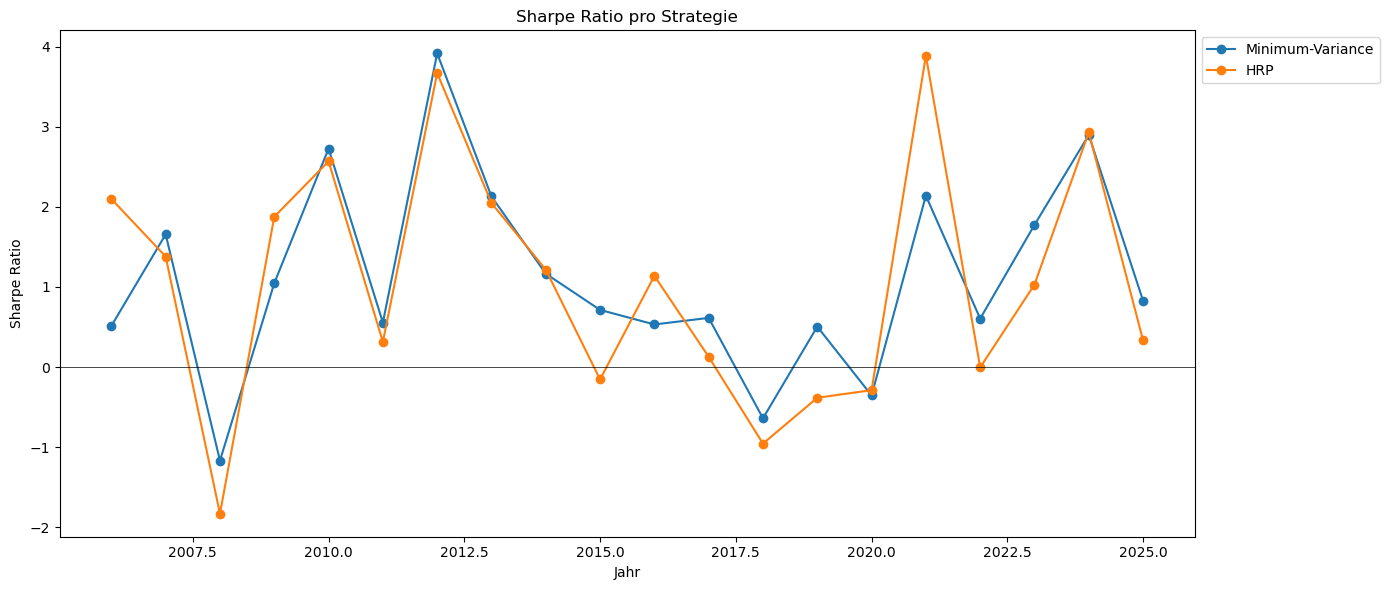

In [65]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [66]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annual_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(annual_sharpe_shrinked)

Equally-Weighted           0.607738
Minimum-Variance           0.811376
Maximum-Diversification    0.791730
Inverse-Volatility         0.595201
Equal-Risk-Contribution    0.656952
HRP                        0.587562
HERC                       0.278794
dtype: float64


In [67]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_total)

print(gesamt_sharpe_shrinked)

Equally-Weighted           2.682605
Minimum-Variance           3.581480
Maximum-Diversification    3.494763
Inverse-Volatility         2.627266
Equal-Risk-Contribution    2.899842
HRP                        2.593548
HERC                       1.230622
dtype: float64


#### Sortino Ratio

In [68]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.077641          2.183173                 3.072880   
2007          1.603521          2.514240                 2.677003   
2008         -1.849933         -2.013401                -2.227772   
2009          2.545972          1.936420                 1.560937   
2010          2.496570          4.381334                 3.683263   
2011          0.147476          0.537776                 0.152322   
2012          4.046631          7.684854                 6.179010   
2013          1.581059          3.166057                 3.229826   
2014          1.721982          1.852803                 1.765026   
2015         -0.785512          0.418907                -0.054605   
2016          1.920777          1.336684                 2.210774   
2017          0.932885          0.677033                 0.067762   
20

In [69]:
#Annualisierte Sortino
annualized_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)
print(annualized_sortino_shrinked)

Equally-Weighted           0.836233
Minimum-Variance           1.122944
Maximum-Diversification    1.096962
Inverse-Volatility         0.816028
Equal-Risk-Contribution    0.896501
HRP                        0.786901
HERC                       0.380286
dtype: float64


In [70]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_total)

print(gesamt_sortino_shrinked)

Equally-Weighted           3.691202
Minimum-Variance           4.956768
Maximum-Diversification    4.842083
Inverse-Volatility         3.602014
Equal-Risk-Contribution    3.957229
HRP                        3.473447
HERC                       1.678613
dtype: float64


In [71]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.103348         -0.081078                -0.075368   
2007         -0.141497         -0.096970                -0.104304   
2008         -0.373133         -0.265344                -0.316410   
2009         -0.185958         -0.125748                -0.178611   
2010         -0.086979         -0.035739                -0.058421   
2011         -0.100825         -0.092814                -0.086713   
2012         -0.038322         -0.018551                -0.016417   
2013         -0.068380         -0.056777                -0.050975   
2014         -0.071786         -0.053797                -0.063219   
2015         -0.218059         -0.124073                -0.145536   
2016         -0.086474         -0.056469                -0.048392   
2017         -0.115091         -0.059614                -0.096287   
20

In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.470674
Minimum-Variance          -0.295225
Maximum-Diversification   -0.365386
Inverse-Volatility        -0.466791
Equal-Risk-Contribution   -0.431329
HRP                       -0.472806
HERC                      -0.441769
dtype: float64>

#### Calmar Ratio

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.735800          1.982262                 3.256743   
2007          0.980493          1.601311                 1.843558   
2008         -0.748485         -0.686386                -0.735541   
2009          1.392313          0.927990                 0.619845   
2010          2.177087          4.725937                 2.846040   
2011          0.058152          0.239445                 0.059428   
2012          5.440724         13.521276                13.460702   
2013          1.650659          2.475591                 2.948367   
2014          1.362109          1.432018                 1.228904   
2015         -0.378281          0.194891                -0.054893   
2016          2.130655          1.201884                 2.629208   
2017          0.448500          0.436393                 0.009828   
20

In [74]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted           6.430698
Minimum-Variance           8.033181
Maximum-Diversification    7.436981
Inverse-Volatility         5.789483
Equal-Risk-Contribution    6.633303
HRP                        4.025790
HERC                       1.716063
dtype: float64>

##### Value at Risk

In [75]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.016121         -0.007784                -0.009826   
2007         -0.011691         -0.007642                -0.009771   
2008         -0.024118         -0.014886                -0.017404   
2009         -0.015467         -0.008779                -0.009536   
2010         -0.010488         -0.005193                -0.006480   
2011         -0.012052         -0.006790                -0.006846   
2012         -0.006959         -0.004440                -0.004813   
2013         -0.010717         -0.005997                -0.006160   
2014         -0.008105         -0.005632                -0.006159   
2015         -0.014700         -0.007479                -0.008822   
2016         -0.014320         -0.007473                -0.008922   
2017         -0.007818         -0.005774                -0.006870   
20

In [76]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.012399
Minimum-Variance          -0.006983
Maximum-Diversification   -0.008039
Inverse-Volatility        -0.011819
Equal-Risk-Contribution   -0.010633
HRP                       -0.009054
HERC                      -0.012781
dtype: float64>

In [77]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.047461
Minimum-Variance          -0.030423
Maximum-Diversification   -0.033677
Inverse-Volatility        -0.042625
Equal-Risk-Contribution   -0.040921
HRP                       -0.041840
HERC                      -0.051816
dtype: float64>

#### Expected Shortfall

In [78]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.024985         -0.016140                -0.016101   
2007         -0.018759         -0.012698                -0.014729   
2008         -0.033490         -0.020210                -0.023449   
2009         -0.018244         -0.011783                -0.013159   
2010         -0.014569         -0.007818                -0.008717   
2011         -0.015852         -0.008839                -0.009467   
2012         -0.009976         -0.005918                -0.006479   
2013         -0.014885         -0.008664                -0.008965   
2014         -0.011782         -0.008329                -0.008540   
2015         -0.019982         -0.013444                -0.014232   
2016         -0.019115         -0.010114                -0.011210   
2017         -0.011415         -0.007841                -0.009828   
20

In [79]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019770
Minimum-Variance          -0.011834
Maximum-Diversification   -0.013120
Inverse-Volatility        -0.018975
Equal-Risk-Contribution   -0.017464
HRP                       -0.015508
HERC                      -0.020984
dtype: float64>

In [80]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.092746
Minimum-Variance          -0.064790
Maximum-Diversification   -0.073424
Inverse-Volatility        -0.088448
Equal-Risk-Contribution   -0.087209
HRP                       -0.087101
HERC                      -0.088575
dtype: float64>

In [81]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.278347
Minimum-Variance          -0.181476
Maximum-Diversification   -0.231926
Inverse-Volatility        -0.264269
Equal-Risk-Contribution   -0.276786
HRP                       -0.274447
HERC                      -0.290101
dtype: float64>

In [82]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([annualized_sharpe,annualized_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.607738  0.836233     -0.470674  6.430698 -0.047461   
Minimum-Variance         0.840102  1.122944     -0.295225  8.033181 -0.030423   
Maximum-Diversification  0.834610  1.096962     -0.365386  7.436981 -0.033677   
Inverse-Volatility       0.598055  0.816028     -0.466791  5.789483 -0.042625   
Equal-Risk-Contribution  0.658045  0.896501     -0.431329  6.633303 -0.040921   
HRP                      0.631525  0.786901     -0.472806  4.025790 -0.041840   
HERC                     0.278794  0.380286     -0.441769  1.716063 -0.051816   

                               ES  
Equally-Weighted        -0.092746  
Minimum-Variance        -0.064790  
Maximum-Diversification -0.073424  
Inverse-Volatility      -0.088448  
Equal-Risk-Contribution -0.087209  
HRP                     -0.087101  
HERC                    -0.088575  


## 2-Jahre Trainingsfenster S&P500

In [83]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'returnsWharton_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [84]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.003207         -0.003242                -0.001644   
1     2007-06-04         -0.006195         -0.005374                -0.003094   
2     2007-06-05          0.002714          0.004742                 0.006570   
3     2007-06-06         -0.005282         -0.005660                -0.007916   
4     2007-06-07          0.000730         -0.000233                -0.000214   
...          ...               ...               ...                      ...   
4668  2025-05-26          0.003942          0.001690                 0.003252   
4669  2025-05-27          0.000908          0.000192                -0.000880   
4670  2025-05-28          0.000764          0.002619                 0.002830   
4671  2025-05-29          0.008073          0.004555                 0.004508   
4672  2025-05-30          0.000965          0.003379                 0.000985

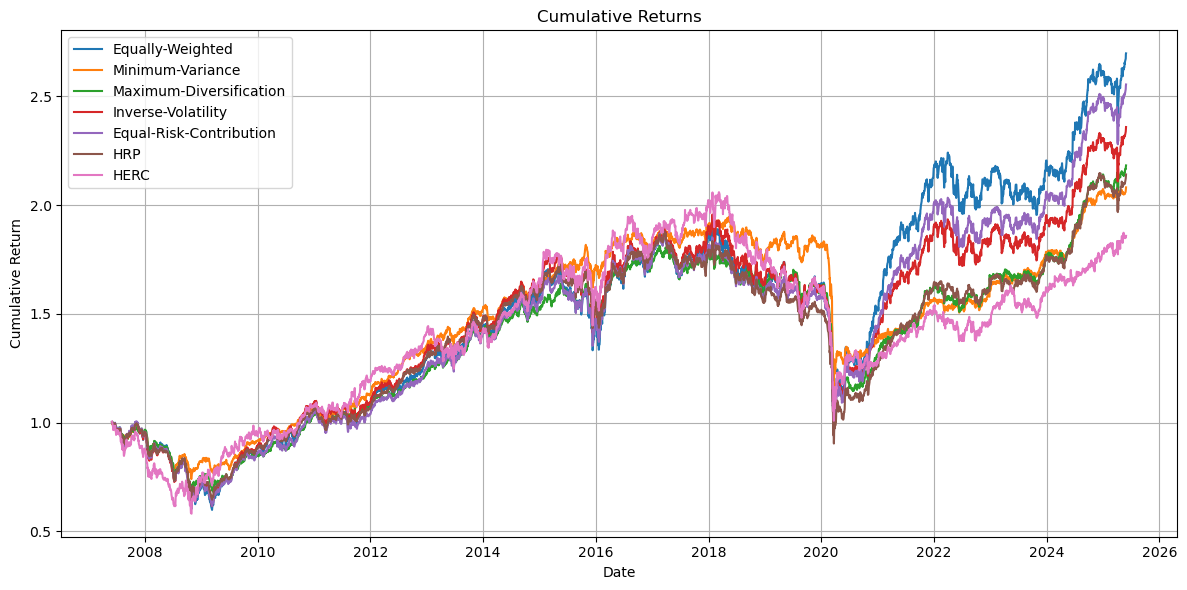

In [85]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.675421         -0.972361                -0.524066   
2008         -1.283891         -1.322382                -1.770337   
2009          1.717771          1.293028                 1.178389   
2010          1.868715          2.816255                 2.954780   
2011          0.015646          0.850435                 0.471888   
2012          2.440024          3.114003                 2.281942   
2013          1.073984          1.888822                 2.367154   
2014          1.251864          1.018396                 1.130850   
2015         -0.628788          0.789745                 0.075399   
2016          1.401976          0.813264                 1.596886   
2017          0.660346          0.771690                 0.251849   
2018         -1.022517         -0.840045                -0.892890   
20

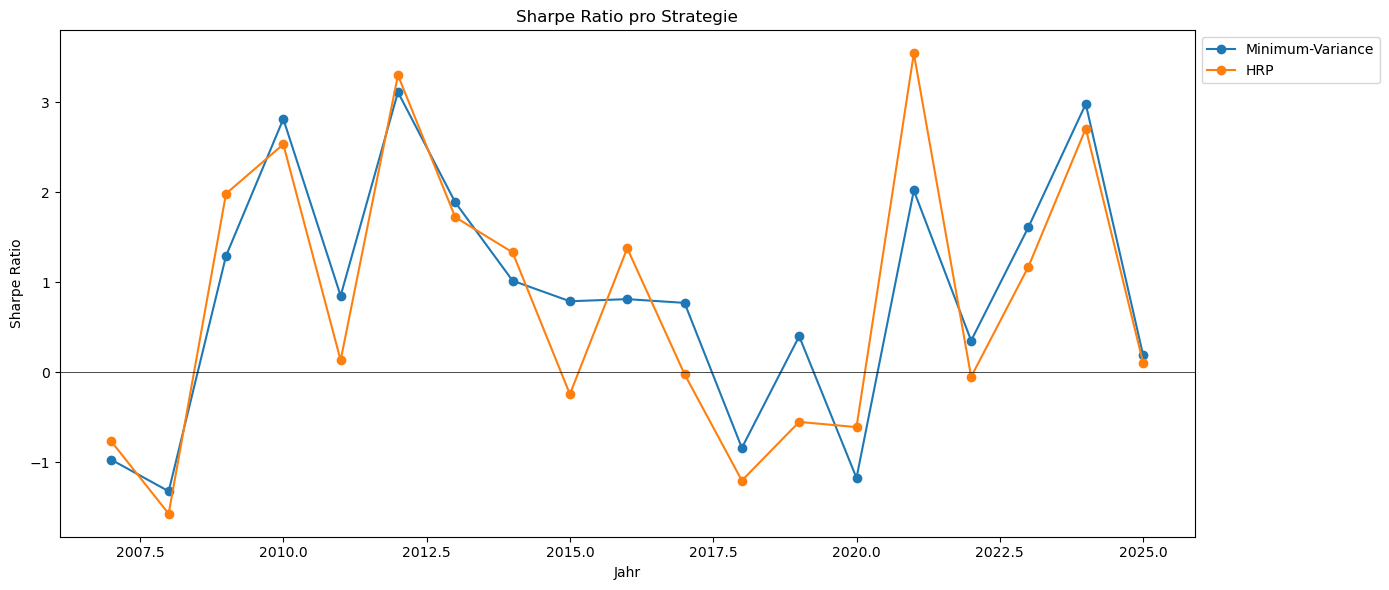

In [87]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

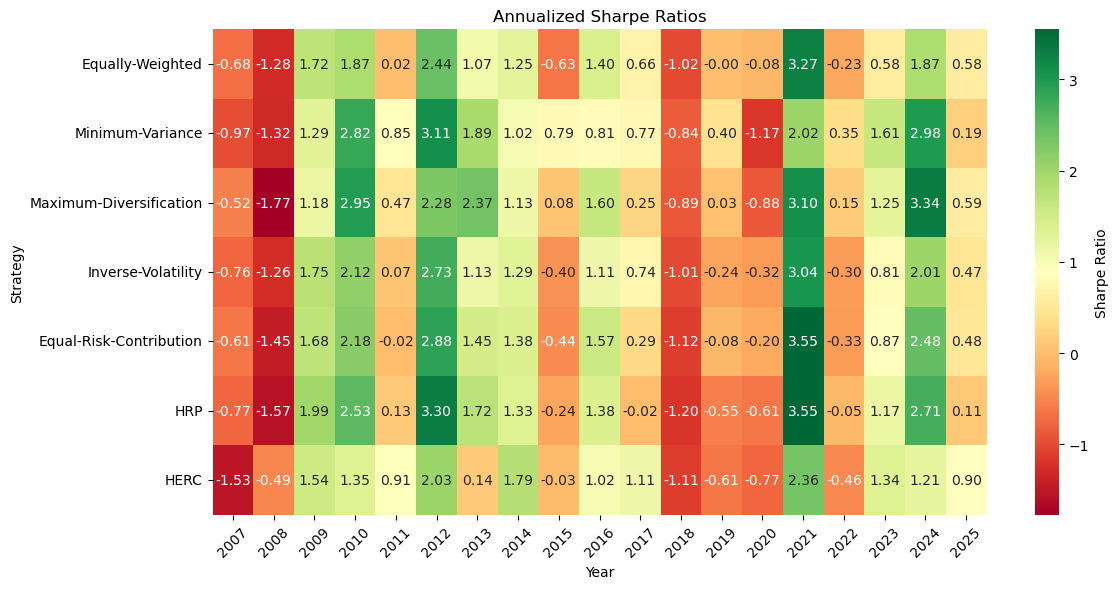

In [88]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4652)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_total_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           2.003078
Minimum-Variance           2.184185
Maximum-Diversification    2.156448
Inverse-Volatility         1.834440
Equal-Risk-Contribution    2.085325
HRP                        1.940624
HERC                       1.355998
dtype: float64


In [90]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(annualized_sharpe_2jahre)

Equally-Weighted           0.466206
Minimum-Variance           0.508358
Maximum-Diversification    0.501903
Inverse-Volatility         0.426957
Equal-Risk-Contribution    0.485349
HRP                        0.451671
HERC                       0.315602
dtype: float64


In [91]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.880980         -1.223473                -0.680892   
2008         -1.648030         -1.670255                -2.147979   
2009          2.568005          1.922783                 1.933936   
2010          2.743189          4.204550                 4.539323   
2011          0.021223          1.247101                 0.672496   
2012          3.698106          5.403117                 3.721597   
2013          1.483978          2.759830                 3.565185   
2014          1.881010          1.403135                 1.597378   
2015         -0.814452          1.076401                 0.100705   
2016          2.128665          1.186424                 2.362751   
2017          0.989135          1.175817                 0.363044   
2018         -1.387982         -1.137745                -1.239201   
20

In [92]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4529)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_total_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           2.712431
Minimum-Variance           2.878439
Maximum-Diversification    2.853570
Inverse-Volatility         2.470211
Equal-Risk-Contribution    2.789436
HRP                        2.566385
HERC                       1.867918
dtype: float64


In [93]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(annualized_sortino_2jahre)

Equally-Weighted           0.639820
Minimum-Variance           0.678979
Maximum-Diversification    0.673113
Inverse-Volatility         0.582684
Equal-Risk-Contribution    0.657984
HRP                        0.605370
HERC                       0.440613
dtype: float64


In [94]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.127701         -0.083692                -0.101677   
2008         -0.363326         -0.223500                -0.306267   
2009         -0.174937         -0.083781                -0.114377   
2010         -0.084520         -0.023725                -0.044045   
2011         -0.100638         -0.083018                -0.073234   
2012         -0.040771         -0.021058                -0.019265   
2013         -0.066448         -0.057974                -0.036250   
2014         -0.072154         -0.050923                -0.059903   
2015         -0.220934         -0.108119                -0.123069   
2016         -0.083375         -0.044798                -0.048381   
2017         -0.116913         -0.041484                -0.085191   
2018         -0.167148         -0.109106                -0.116608   
20

In [95]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.507527
Minimum-Variance          -0.402359
Maximum-Diversification   -0.434661
Inverse-Volatility        -0.518133
Equal-Risk-Contribution   -0.499244
HRP                       -0.519124
HERC                      -0.510341
dtype: float64>

In [96]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.692577         -0.900834                -0.537437   
2008         -0.704895         -0.623381                -0.717972   
2009          1.488457          1.357317                 1.059964   
2010          2.478419          6.804413                 4.873672   
2011         -0.042966          0.648333                 0.414309   
2012          4.720237          8.925291                 7.318039   
2013          1.607644          2.130798                 4.326029   
2014          1.472925          1.174507                 1.168532   
2015         -0.388449          0.587090                 0.022008   
2016          2.480297          1.313561                 2.761349   
2017          0.470461          1.010955                 0.167702   
2018         -0.719927         -0.659245                -0.696893   
20

In [97]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           3.346038
Minimum-Variance           2.688792
Maximum-Diversification    2.721450
Inverse-Volatility         2.623664
Equal-Risk-Contribution    3.114932
HRP                        2.198321
HERC                       1.682769
dtype: float64>

In [98]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.013248         -0.007422                -0.009979   
2008         -0.024432         -0.012265                -0.017487   
2009         -0.014913         -0.008549                -0.009103   
2010         -0.010585         -0.004713                -0.006562   
2011         -0.011801         -0.006054                -0.006638   
2012         -0.007290         -0.004323                -0.005381   
2013         -0.010438         -0.005714                -0.006038   
2014         -0.007535         -0.006472                -0.006290   
2015         -0.014306         -0.007915                -0.009687   
2016         -0.013964         -0.007432                -0.008912   
2017         -0.008106         -0.005195                -0.006308   
2018         -0.012645         -0.008750                -0.009844   
20

In [99]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.012599
Minimum-Variance          -0.007262
Maximum-Diversification   -0.008095
Inverse-Volatility        -0.011704
Equal-Risk-Contribution   -0.010770
HRP                       -0.008917
HERC                      -0.012649
dtype: float64>

In [100]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.049476
Minimum-Variance          -0.031396
Maximum-Diversification   -0.034127
Inverse-Volatility        -0.043273
Equal-Risk-Contribution   -0.044248
HRP                       -0.040070
HERC                      -0.045632
dtype: float64>

In [101]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.019852         -0.012026                -0.015295   
2008         -0.033652         -0.017584                -0.022540   
2009         -0.018106         -0.011717                -0.011264   
2010         -0.014813         -0.007822                -0.009336   
2011         -0.015831         -0.008366                -0.009019   
2012         -0.010037         -0.006318                -0.006855   
2013         -0.015051         -0.009097                -0.008560   
2014         -0.011563         -0.008597                -0.008562   
2015         -0.020128         -0.012332                -0.013833   
2016         -0.018885         -0.009566                -0.010807   
2017         -0.011384         -0.006702                -0.008672   
2018         -0.014917         -0.011279                -0.011561   
20

In [102]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.019913
Minimum-Variance          -0.012237
Maximum-Diversification   -0.013572
Inverse-Volatility        -0.018908
Equal-Risk-Contribution   -0.017772
HRP                       -0.015240
HERC                      -0.019777
dtype: float64>

In [103]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.096754
Minimum-Variance          -0.072393
Maximum-Diversification   -0.079884
Inverse-Volatility        -0.093367
Equal-Risk-Contribution   -0.092629
HRP                       -0.087004
HERC                      -0.084370
dtype: float64>

In [104]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.255233
Minimum-Variance          -0.244528
Maximum-Diversification   -0.219122
Inverse-Volatility        -0.236631
Equal-Risk-Contribution   -0.254902
HRP                       -0.231912
HERC                      -0.207152
dtype: float64>

In [105]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([annualized_sharpe_2jahre, annualized_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.466206  0.639820     -0.507527  3.346038 -0.049476   
Minimum-Variance         0.508358  0.678979     -0.402359  2.688792 -0.031396   
Maximum-Diversification  0.501903  0.673113     -0.434661  2.721450 -0.034127   
Inverse-Volatility       0.426957  0.582684     -0.518133  2.623664 -0.043273   
Equal-Risk-Contribution  0.485349  0.657984     -0.499244  3.114932 -0.044248   
HRP                      0.451671  0.605370     -0.519124  2.198321 -0.040070   
HERC                     0.315602  0.440613     -0.510341  1.682769 -0.045632   

                               ES  
Equally-Weighted        -0.096754  
Minimum-Variance        -0.072393  
Maximum-Diversification -0.079884  
Inverse-Volatility      -0.093367  
Equal-Risk-Contribution -0.092629  
HRP                     -0.087004  
HERC                    -0.084370  


## S&P 500 2Jahre Shrinked

In [106]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnsWhartonshrinked_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [107]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.003207         -0.002881                -0.002053   
1     2007-06-04         -0.006195         -0.004458                -0.002687   
2     2007-06-05          0.002714          0.004706                 0.006210   
3     2007-06-06         -0.005282         -0.004517                -0.007005   
4     2007-06-07          0.000730         -0.001288                -0.000720   
...          ...               ...               ...                      ...   
4668  2025-05-26          0.003942          0.002382                 0.003024   
4669  2025-05-27          0.000908          0.000321                -0.000583   
4670  2025-05-28          0.000764          0.002449                 0.002900   
4671  2025-05-29          0.008073          0.004714                 0.004949   
4672  2025-05-30          0.000965          0.002993                 0.000922

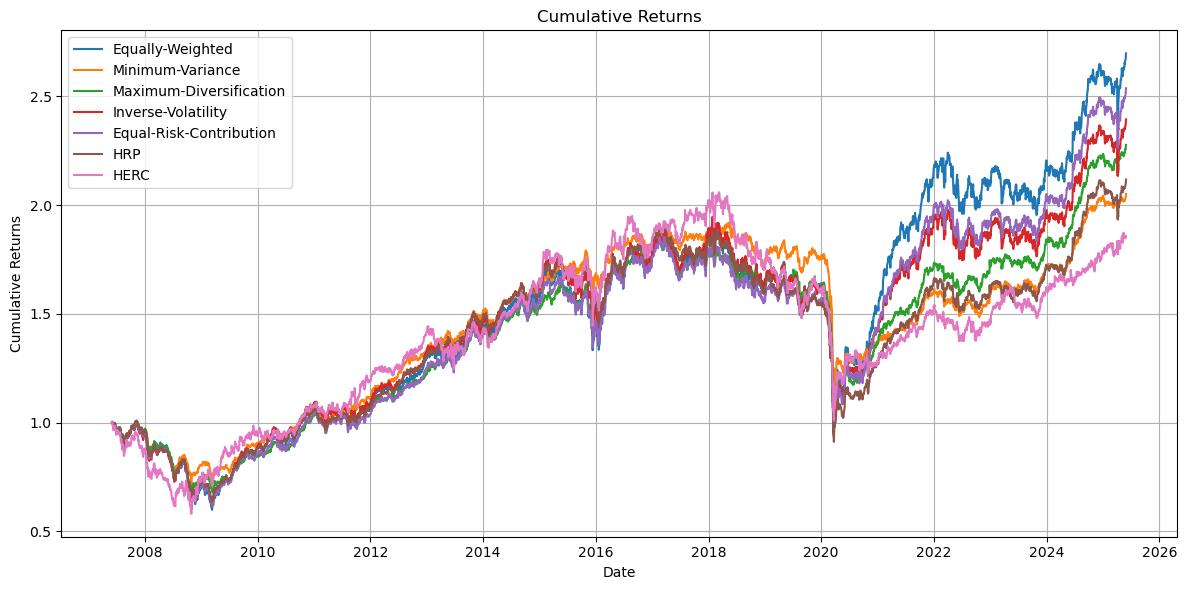

In [108]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.675421         -0.701645                -0.445133   
2008         -1.283891         -1.539715                -1.813779   
2009          1.717771          1.410028                 1.212030   
2010          1.868715          2.991398                 2.917378   
2011          0.015646          0.737595                 0.396463   
2012          2.440024          3.155974                 2.439785   
2013          1.073984          1.955558                 2.359078   
2014          1.251864          1.189440                 1.200682   
2015         -0.628788          0.500258                 0.005096   
2016          1.401976          1.106825                 1.814093   
2017          0.660346          0.552840                 0.095369   
2018         -1.022517         -0.824688                -0.905385   
20

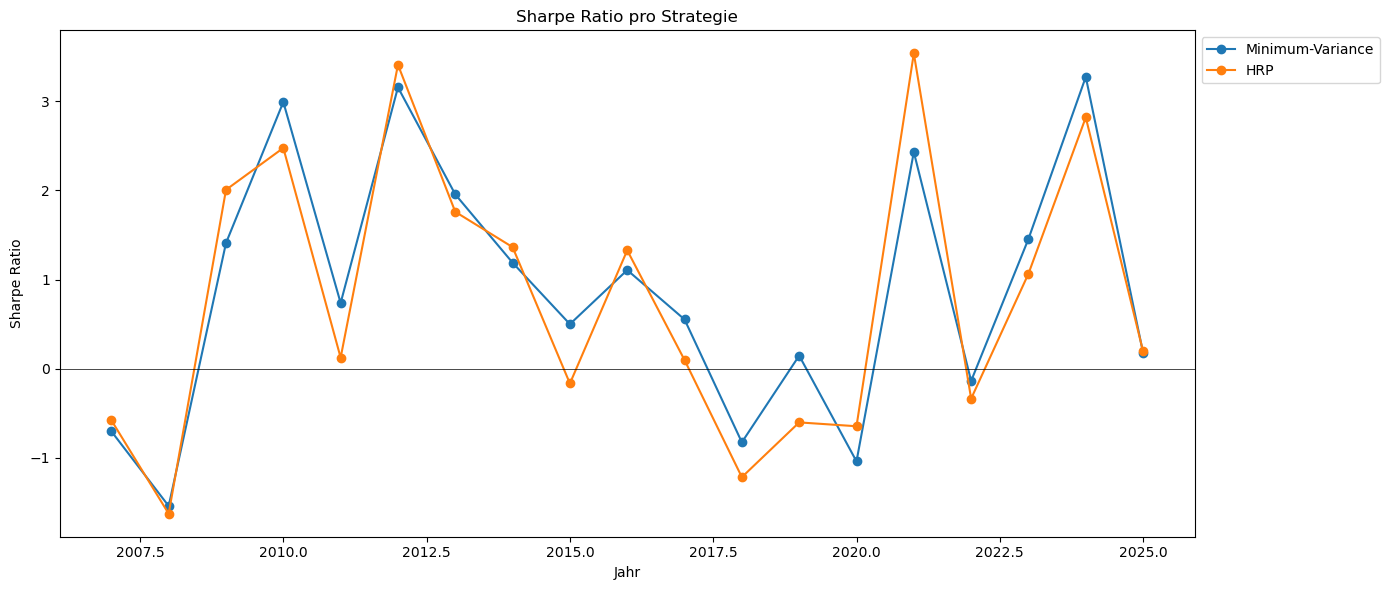

In [110]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.466206
Minimum-Variance           0.491871
Maximum-Diversification    0.523662
Inverse-Volatility         0.429595
Equal-Risk-Contribution    0.481421
HRP                        0.437165
HERC                       0.315602
dtype: float64


In [112]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.880980         -0.896174                -0.580587   
2008         -1.648030         -1.901623                -2.199765   
2009          2.568005          2.158312                 1.994985   
2010          2.743189          4.477205                 4.465285   
2011          0.021223          1.064229                 0.560460   
2012          3.698106          5.464603                 4.006752   
2013          1.483978          2.867438                 3.547868   
2014          1.881010          1.661157                 1.708889   
2015         -0.814452          0.664310                 0.006753   
2016          2.128665          1.608852                 2.698944   
2017          0.989135          0.831121                 0.135780   
2018         -1.387982         -1.117554                -1.254808   
20

In [113]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.639820
Minimum-Variance           0.658498
Maximum-Diversification    0.702115
Inverse-Volatility         0.586871
Equal-Risk-Contribution    0.652781
HRP                        0.584337
HERC                       0.440613
dtype: float64


In [114]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.127701         -0.084943                -0.098221   
2008         -0.363326         -0.252455                -0.317441   
2009         -0.174937         -0.088937                -0.113580   
2010         -0.084520         -0.024924                -0.046152   
2011         -0.100638         -0.083118                -0.077266   
2012         -0.040771         -0.021176                -0.019128   
2013         -0.066448         -0.057034                -0.037638   
2014         -0.072154         -0.049342                -0.058882   
2015         -0.220934         -0.121750                -0.133951   
2016         -0.083375         -0.043619                -0.047465   
2017         -0.116913         -0.049006                -0.092074   
2018         -0.167148         -0.106874                -0.117951   
20

In [115]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.507527
Minimum-Variance          -0.417068
Maximum-Diversification   -0.443601
Inverse-Volatility        -0.518353
Equal-Risk-Contribution   -0.498796
HRP                       -0.526320
HERC                      -0.510341
dtype: float64>

In [116]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.692577         -0.675078                -0.472558   
2008         -0.704895         -0.657609                -0.716578   
2009          1.488457          1.378469                 1.090737   
2010          2.478419          6.752445                 4.646143   
2011         -0.042966          0.549482                 0.319582   
2012          4.720237          8.872413                 7.788154   
2013          1.607644          2.246821                 4.164947   
2014          1.472925          1.425614                 1.261332   
2015         -0.388449          0.333134                -0.028717   
2016          2.480297          1.866420                 3.292358   
2017          0.470461          0.607091                 0.044880   
2018         -0.719927         -0.661316                -0.697805   
20

In [117]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           3.346038
Minimum-Variance           2.522362
Maximum-Diversification    2.878631
Inverse-Volatility         2.690661
Equal-Risk-Contribution    3.083328
HRP                        2.124488
HERC                       1.682769
dtype: float64>

In [118]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.013248         -0.007959                -0.009654   
2008         -0.024432         -0.013186                -0.016883   
2009         -0.014913         -0.008478                -0.008400   
2010         -0.010585         -0.004338                -0.006768   
2011         -0.011801         -0.006251                -0.006740   
2012         -0.007290         -0.004402                -0.005432   
2013         -0.010438         -0.005654                -0.005953   
2014         -0.007535         -0.005782                -0.006064   
2015         -0.014306         -0.008423                -0.009529   
2016         -0.013964         -0.007398                -0.008560   
2017         -0.008106         -0.005429                -0.006515   
2018         -0.012645         -0.008804                -0.009558   
20

In [119]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.012599
Minimum-Variance          -0.007333
Maximum-Diversification   -0.008215
Inverse-Volatility        -0.011950
Equal-Risk-Contribution   -0.010909
HRP                       -0.009167
HERC                      -0.012649
dtype: float64>

In [120]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.049476
Minimum-Variance          -0.031424
Maximum-Diversification   -0.034302
Inverse-Volatility        -0.044109
Equal-Risk-Contribution   -0.044175
HRP                       -0.043377
HERC                      -0.045632
dtype: float64>

In [121]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.019852         -0.012480                -0.015156   
2008         -0.033652         -0.019258                -0.023163   
2009         -0.018106         -0.010925                -0.010942   
2010         -0.014813         -0.007778                -0.009458   
2011         -0.015831         -0.008498                -0.009018   
2012         -0.010037         -0.006257                -0.006683   
2013         -0.015051         -0.009020                -0.008615   
2014         -0.011563         -0.008442                -0.008477   
2015         -0.020128         -0.013391                -0.014319   
2016         -0.018885         -0.009898                -0.011047   
2017         -0.011384         -0.007001                -0.008890   
2018         -0.014917         -0.011337                -0.011537   
20

In [122]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019913
Minimum-Variance          -0.012373
Maximum-Diversification   -0.013642
Inverse-Volatility        -0.019148
Equal-Risk-Contribution   -0.017817
HRP                       -0.015661
HERC                      -0.019777
dtype: float64>

In [123]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.096754
Minimum-Variance          -0.075258
Maximum-Diversification   -0.080758
Inverse-Volatility        -0.094412
Equal-Risk-Contribution   -0.092219
HRP                       -0.090472
HERC                      -0.084370
dtype: float64>

In [124]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.255233
Minimum-Variance          -0.225730
Maximum-Diversification   -0.226679
Inverse-Volatility        -0.240775
Equal-Risk-Contribution   -0.255035
HRP                       -0.247427
HERC                      -0.207152
dtype: float64>

In [127]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.466206  0.639820     -0.507527  3.346038 -0.049476   
Minimum-Variance         0.491871  0.658498     -0.417068  2.522362 -0.031424   
Maximum-Diversification  0.523662  0.702115     -0.443601  2.878631 -0.034302   
Inverse-Volatility       0.429595  0.586871     -0.518353  2.690661 -0.044109   
Equal-Risk-Contribution  0.481421  0.652781     -0.498796  3.083328 -0.044175   
HRP                      0.437165  0.584337     -0.526320  2.124488 -0.043377   
HERC                     0.315602  0.440613     -0.510341  1.682769 -0.045632   

                               ES  
Equally-Weighted        -0.096754  
Minimum-Variance        -0.075258  
Maximum-Diversification -0.080758  
Inverse-Volatility      -0.094412  
Equal-Risk-Contribution -0.092219  
HRP                     -0.090472  
HERC                    -0.084370  


## S&P500 3 Jahre

In [128]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre = pd.read_csv(
    'returnsWharton_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [129]:
df_SP500_3jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.010231         -0.007005                -0.008316   
1     2008-06-03         -0.004530         -0.000986                -0.001624   
2     2008-06-04         -0.005979         -0.004654                -0.008762   
3     2008-06-05          0.010282          0.004120                 0.006163   
4     2008-06-06          0.001310         -0.001767                 0.002013   
...          ...               ...               ...                      ...   
4418  2025-05-26          0.004801          0.002980                 0.006392   
4419  2025-05-27         -0.000012         -0.000735                -0.001835   
4420  2025-05-28         -0.000024          0.002507                 0.002493   
4421  2025-05-29          0.009250          0.005703                 0.007419   
4422  2025-05-30          0.000720          0.003451                 0.001507

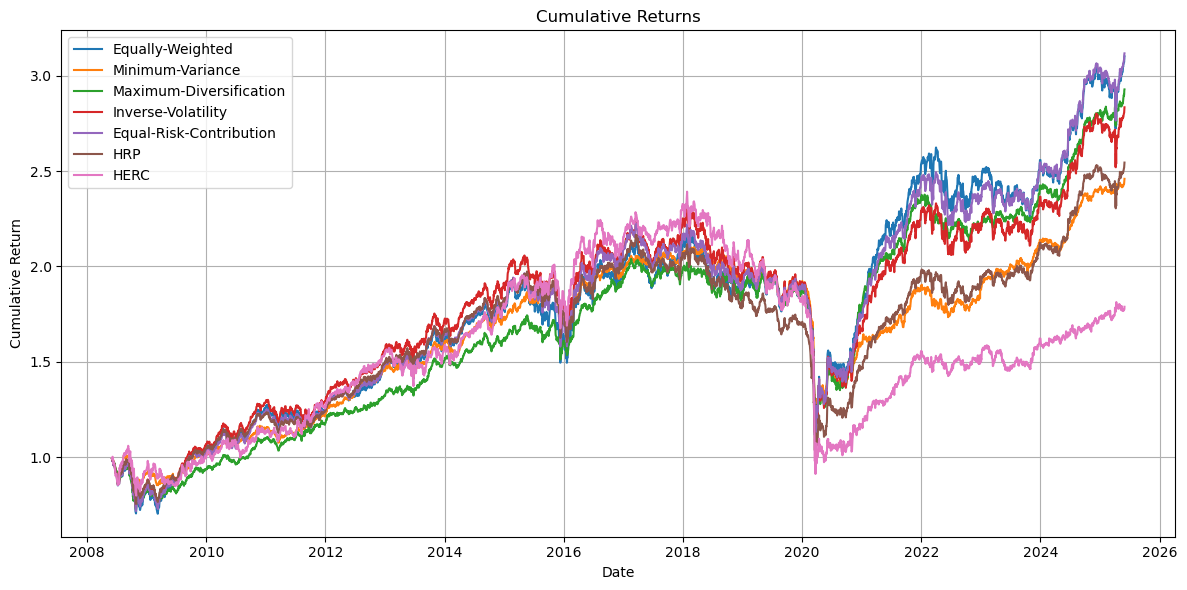

In [130]:
df_SP500_3jahre["Date"] = pd.to_datetime(df_SP500_3jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre = df_SP500_3jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sharpe_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.211872         -0.954224                -1.859255   
2009          1.728447          1.356220                 1.405333   
2010          1.807783          2.256043                 2.325866   
2011         -0.032303          0.896551                 0.977390   
2012          2.249979          2.989159                 1.856854   
2013          0.938951          1.413225                 2.012611   
2014          1.152908          1.363853                 1.215221   
2015         -0.598673          0.574524                -0.035524   
2016          1.386549          1.203134                 2.253210   
2017          0.796317          0.855969                 0.395210   
2018         -0.978121         -0.793869                -0.624864   
2019          0.059115         -0.095853                 0.095072   
20

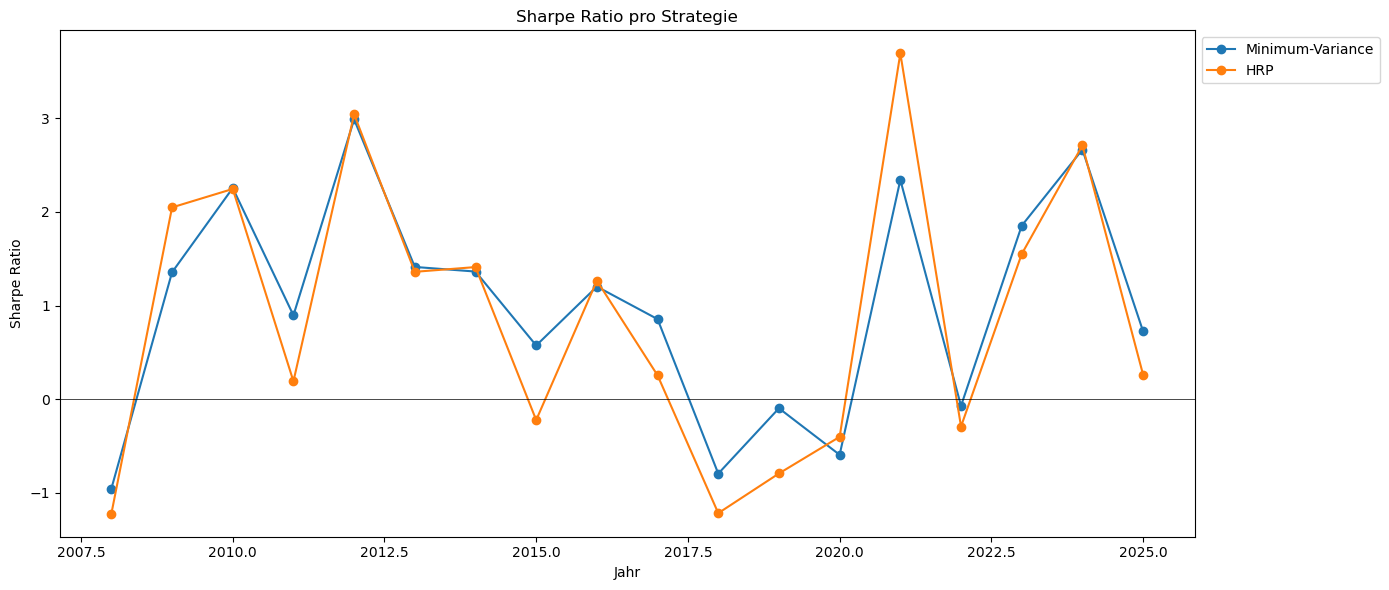

In [132]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre.columns
years = sharpe_jahresweise_3jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [133]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4394)  # 252 Handelstage

gesamt_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_total_3jahre)

print(gesamt_sharpe_3jahre)

Equally-Weighted           2.263302
Minimum-Variance           2.488995
Maximum-Diversification    2.845345
Inverse-Volatility         2.162949
Equal-Risk-Contribution    2.488166
HRP                        2.283107
HERC                       1.261206
dtype: float64


In [134]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_annual_3jahre)

print(annualized_sharpe_3jahre)

Equally-Weighted           0.542017
Minimum-Variance           0.596066
Maximum-Diversification    0.681405
Inverse-Volatility         0.517984
Equal-Risk-Contribution    0.595867
HRP                        0.546760
HERC                       0.302034
dtype: float64


In [135]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sortino_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.572804         -1.235120                -2.262585   
2009          2.576162          1.951174                 2.142173   
2010          2.633299          3.339216                 3.515658   
2011         -0.043725          1.339088                 1.428014   
2012          3.384007          5.040362                 2.963754   
2013          1.294143          2.001440                 2.993074   
2014          1.735169          1.918002                 1.749773   
2015         -0.773536          0.770605                -0.046274   
2016          2.108507          1.782073                 3.481760   
2017          1.203116          1.293878                 0.578934   
2018         -1.330685         -1.075210                -0.886813   
2019          0.082798         -0.135331                 0.135083   
20

In [136]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4277)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre = df_SP500_3jahre.apply(sortino_total_3jahre)

print(gesamt_sortino_3jahre)

Equally-Weighted           3.080774
Minimum-Variance           3.303577
Maximum-Diversification    3.757631
Inverse-Volatility         2.930620
Equal-Risk-Contribution    3.343839
HRP                        3.039891
HERC                       1.691111
dtype: float64


In [137]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_3jahre = df_SP500_3jahre.apply(sortino_annual_3jahre)

print(annualized_sortino_3jahre)

Equally-Weighted           0.747809
Minimum-Variance           0.801891
Maximum-Diversification    0.912105
Inverse-Volatility         0.711361
Equal-Risk-Contribution    0.811664
HRP                        0.737885
HERC                       0.410490
dtype: float64


In [138]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.288411         -0.195710                -0.270068   
2009         -0.170865         -0.082750                -0.088570   
2010         -0.086731         -0.020592                -0.049841   
2011         -0.104020         -0.070599                -0.064199   
2012         -0.044338         -0.024220                -0.025365   
2013         -0.070215         -0.062837                -0.037318   
2014         -0.073528         -0.049193                -0.058652   
2015         -0.222101         -0.110949                -0.132807   
2016         -0.086140         -0.059571                -0.047865   
2017         -0.117481         -0.039237                -0.070729   
2018         -0.166664         -0.104334                -0.098513   
2019         -0.116695         -0.094719                -0.087076   
20

In [139]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_total_3jahre = df_SP500_3jahre.apply(maximum_drawdown)

max_drawdown_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.507195
Minimum-Variance          -0.451958
Maximum-Diversification   -0.435042
Inverse-Volatility        -0.531820
Equal-Risk-Contribution   -0.501682
HRP                       -0.539349
HERC                      -0.618708
dtype: float64>

In [140]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.973343         -0.700258                -1.026560   
2009          1.550792          1.318518                 1.513751   
2010          2.314653          6.226302                 3.338428   
2011         -0.090065          0.811859                 1.091966   
2012          3.984409          7.535637                 4.580868   
2013          1.345567          1.529877                 3.673204   
2014          1.331278          1.652007                 1.233298   
2015         -0.374162          0.421487                -0.056990   
2016          2.448502          1.496985                 4.190507   
2017          0.571711          1.117664                 0.312495   
2018         -0.701417         -0.622892                -0.597080   
2019          0.009918         -0.106517                 0.051338   
20

In [141]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_total_2_3jahre = df_SP500_3jahre.apply(calmar_ratio_total)

calmar_total_2_3jahre.info

<bound method Series.info of Equally-Weighted           4.143201
Minimum-Variance           3.228420
Maximum-Diversification    4.431530
Inverse-Volatility         3.448992
Equal-Risk-Contribution    4.219822
HRP                        2.863362
HERC                       1.274270
dtype: float64>

In [142]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.027330         -0.015706                -0.019001   
2009         -0.015254         -0.007763                -0.008330   
2010         -0.010952         -0.005079                -0.006945   
2011         -0.012170         -0.006744                -0.007200   
2012         -0.007051         -0.004448                -0.005431   
2013         -0.010555         -0.006046                -0.005550   
2014         -0.007339         -0.005869                -0.005342   
2015         -0.014305         -0.007919                -0.010590   
2016         -0.013983         -0.006926                -0.007851   
2017         -0.008302         -0.004938                -0.005634   
2018         -0.012512         -0.008462                -0.009218   
2019         -0.009995         -0.007844                -0.008436   
20

In [143]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_total_3jahre = df_SP500_3jahre.apply(value_at_risk_func)

var_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.012612
Minimum-Variance          -0.007184
Maximum-Diversification   -0.008224
Inverse-Volatility        -0.012042
Equal-Risk-Contribution   -0.010946
HRP                       -0.009182
HERC                      -0.012585
dtype: float64>

In [144]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre = monthly_returns_3jahre.apply(value_at_risk_func)

monthly_var_3jahre.info

<bound method Series.info of Equally-Weighted          -0.049088
Minimum-Variance          -0.033816
Maximum-Diversification   -0.034275
Inverse-Volatility        -0.044128
Equal-Risk-Contribution   -0.042517
HRP                       -0.038822
HERC                      -0.048144
dtype: float64>

In [145]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.036345         -0.022412                -0.027700   
2009         -0.018272         -0.011048                -0.010841   
2010         -0.014842         -0.007534                -0.009177   
2011         -0.015633         -0.008253                -0.009542   
2012         -0.010115         -0.006580                -0.007258   
2013         -0.015451         -0.010009                -0.008850   
2014         -0.011485         -0.008350                -0.007775   
2015         -0.020505         -0.013444                -0.014839   
2016         -0.019426         -0.009634                -0.010682   
2017         -0.011243         -0.006376                -0.007924   
2018         -0.014965         -0.010688                -0.011330   
2019         -0.013132         -0.010761                -0.011258   
20

In [146]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_total_3jahre = df_SP500_3jahre.apply(expected_shortfall)

es_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.019990
Minimum-Variance          -0.013148
Maximum-Diversification   -0.014224
Inverse-Volatility        -0.019250
Equal-Risk-Contribution   -0.017867
HRP                       -0.015889
HERC                      -0.020717
dtype: float64>

In [147]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre = monthly_returns_3jahre.apply(expected_shortfall)

monthly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.091564
Minimum-Variance          -0.075604
Maximum-Diversification   -0.078614
Inverse-Volatility        -0.089016
Equal-Risk-Contribution   -0.087288
HRP                       -0.084291
HERC                      -0.095865
dtype: float64>

In [148]:
yearly_returns_3jahre = df_SP500_3jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre  = yearly_returns_3jahre.apply(expected_shortfall)

yearly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.175947
Minimum-Variance          -0.168243
Maximum-Diversification   -0.173607
Inverse-Volatility        -0.140958
Equal-Risk-Contribution   -0.162108
HRP                       -0.135074
HERC                      -0.361660
dtype: float64>

In [149]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre = pd.concat([annualized_sharpe_3jahre, annualized_sortino_3jahre, max_drawdown_total_3jahre, calmar_total_2_3jahre, monthly_var_3jahre, monthly_es_3jahre], axis=1)
Zusammenfassung_3jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.542017  0.747809     -0.507195  4.143201 -0.049088   
Minimum-Variance         0.596066  0.801891     -0.451958  3.228420 -0.033816   
Maximum-Diversification  0.681405  0.912105     -0.435042  4.431530 -0.034275   
Inverse-Volatility       0.517984  0.711361     -0.531820  3.448992 -0.044128   
Equal-Risk-Contribution  0.595867  0.811664     -0.501682  4.219822 -0.042517   
HRP                      0.546760  0.737885     -0.539349  2.863362 -0.038822   
HERC                     0.302034  0.410490     -0.618708  1.274270 -0.048144   

                               ES  
Equally-Weighted        -0.091564  
Minimum-Variance        -0.075604  
Maximum-Diversification -0.078614  
Inverse-Volatility      -0.089016  
Equal-Risk-Contribution -0.087288  
HRP                     -0.084291  
HERC                    -0.095865  


## S&P500 3 Jahre Shrinked

In [150]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre_shrinked = pd.read_csv(
    'returnsWhartonshrinked_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [151]:
df_SP500_3jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.010231         -0.008534                -0.008672   
1     2008-06-03         -0.004530         -0.001993                -0.002111   
2     2008-06-04         -0.005979         -0.004981                -0.008840   
3     2008-06-05          0.010282          0.003234                 0.005343   
4     2008-06-06          0.001310         -0.000690                 0.002776   
...          ...               ...               ...                      ...   
4418  2025-05-26          0.004801          0.003742                 0.006292   
4419  2025-05-27         -0.000012         -0.000685                -0.001880   
4420  2025-05-28         -0.000024          0.002599                 0.002547   
4421  2025-05-29          0.009250          0.005934                 0.007633   
4422  2025-05-30          0.000720          0.003098                 0.001362

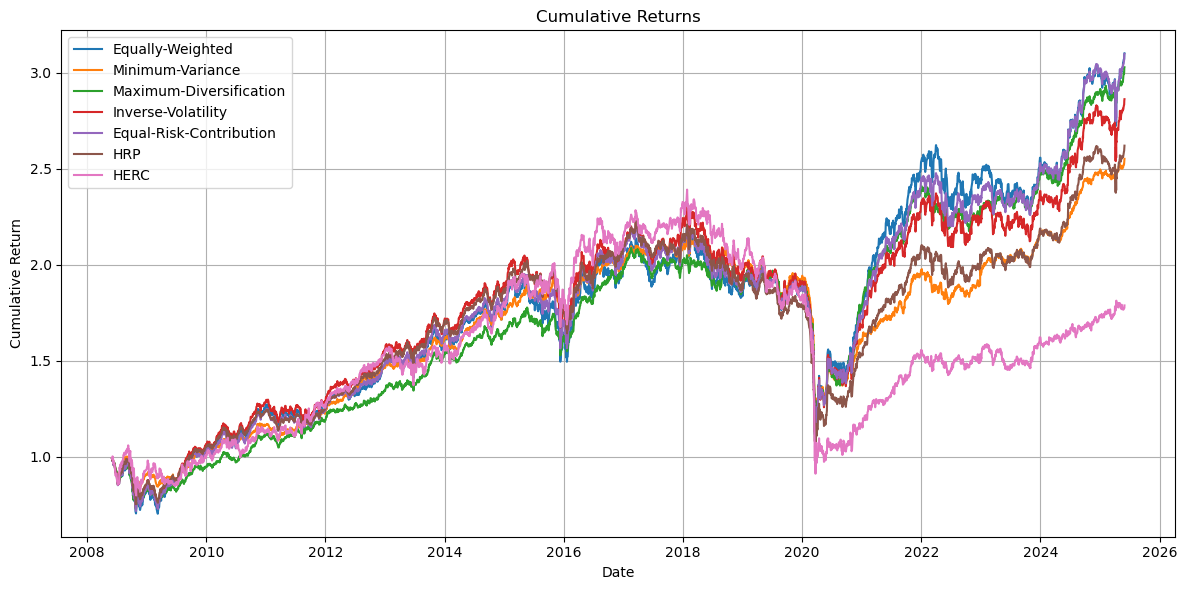

In [152]:
df_SP500_3jahre_shrinked["Date"] = pd.to_datetime(df_SP500_3jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre_shrinked = df_SP500_3jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [153]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sharpe_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.211872         -1.029055                -1.811987   
2009          1.728447          1.565797                 1.488831   
2010          1.807783          2.396347                 2.340270   
2011         -0.032303          0.869139                 0.944325   
2012          2.249979          2.983246                 1.974069   
2013          0.938951          1.452430                 2.002362   
2014          1.152908          1.407331                 1.266396   
2015         -0.598673          0.424487                -0.087239   
2016          1.386549          1.414383                 2.305199   
2017          0.796317          0.762063                 0.288568   
2018         -0.978121         -0.770948                -0.637377   
2019          0.059115         -0.157833                 0.086341   
20

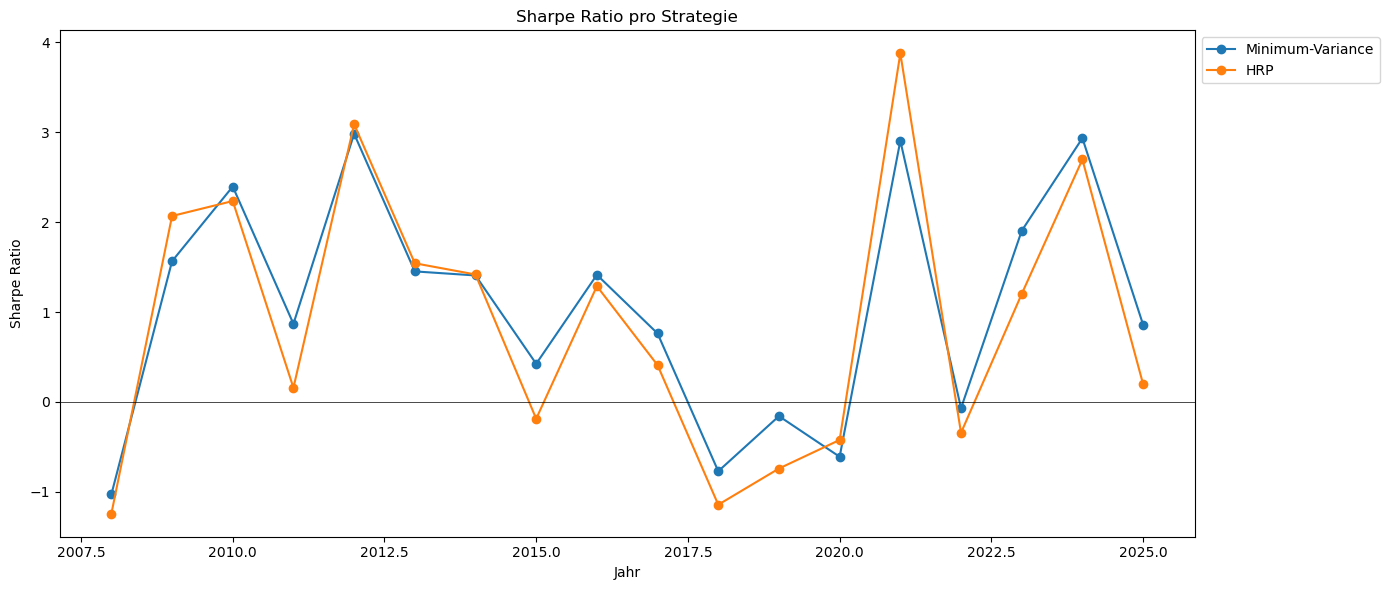

In [154]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre_shrinked.columns
years = sharpe_jahresweise_3jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [155]:
gesamt_sharpe_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sharpe_annual_3jahre)

print(gesamt_sharpe_3jahre_shrinked)

Equally-Weighted           0.542017
Minimum-Variance           0.619103
Maximum-Diversification    0.700322
Inverse-Volatility         0.520051
Equal-Risk-Contribution    0.592027
HRP                        0.557955
HERC                       0.302034
dtype: float64


In [156]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sortino_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.572804         -1.319398                -2.204636   
2009          2.576162          2.299102                 2.275106   
2010          2.633299          3.558518                 3.541771   
2011         -0.043725          1.289051                 1.372247   
2012          3.384007          4.995806                 3.165582   
2013          1.294143          2.066356                 2.972795   
2014          1.735169          1.988382                 1.827754   
2015         -0.773536          0.560704                -0.113394   
2016          2.108507          2.097386                 3.566897   
2017          1.203116          1.151239                 0.419277   
2018         -1.330685         -1.045195                -0.903834   
2019          0.082798         -0.220619                 0.122500   
20

In [157]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sortino_annual_3jahre)

print(gesamt_sortino_3jahre_shrinked)

Equally-Weighted           0.747809
Minimum-Variance           0.831578
Maximum-Diversification    0.938446
Inverse-Volatility         0.714742
Equal-Risk-Contribution    0.806535
HRP                        0.752141
HERC                       0.410490
dtype: float64


In [158]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.288411         -0.201788                -0.267839   
2009         -0.170865         -0.083141                -0.089798   
2010         -0.086731         -0.023242                -0.052460   
2011         -0.104020         -0.070999                -0.064792   
2012         -0.044338         -0.024077                -0.025328   
2013         -0.070215         -0.063131                -0.038875   
2014         -0.073528         -0.048746                -0.058208   
2015         -0.222101         -0.120251                -0.140190   
2016         -0.086140         -0.064496                -0.050601   
2017         -0.117481         -0.042512                -0.075331   
2018         -0.166664         -0.102827                -0.099272   
2019         -0.116695         -0.095098                -0.086372   
20

In [159]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.507195
Minimum-Variance          -0.459300
Maximum-Diversification   -0.442769
Inverse-Volatility        -0.530586
Equal-Risk-Contribution   -0.501166
HRP                       -0.533655
HERC                      -0.618708
dtype: float64>

In [160]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.973343         -0.738603                -1.016654   
2009          1.550792          1.502506                 1.587917   
2010          2.314653          5.752629                 3.221710   
2011         -0.090065          0.763120                 1.021142   
2012          3.984409          7.530052                 4.857539   
2013          1.345567          1.569692                 3.514099   
2014          1.331278          1.712513                 1.291279   
2015         -0.374162          0.287296                -0.089374   
2016          2.448502          1.678789                 4.152768   
2017          0.571711          0.922628                 0.211889   
2018         -0.701417         -0.619809                -0.605491   
2019          0.009918         -0.152015                 0.043156   
20

In [161]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_total_2_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted           4.143201
Minimum-Variance           3.379445
Maximum-Diversification    4.582138
Inverse-Volatility         3.510609
Equal-Risk-Contribution    4.187072
HRP                        3.036918
HERC                       1.274270
dtype: float64>

In [162]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.027330         -0.015765                -0.019076   
2009         -0.015254         -0.008078                -0.008673   
2010         -0.010952         -0.004917                -0.006853   
2011         -0.012170         -0.006560                -0.007257   
2012         -0.007051         -0.004414                -0.005389   
2013         -0.010555         -0.005953                -0.005789   
2014         -0.007339         -0.005741                -0.005259   
2015         -0.014305         -0.007608                -0.010156   
2016         -0.013983         -0.007235                -0.008024   
2017         -0.008302         -0.005147                -0.005870   
2018         -0.012512         -0.008441                -0.009479   
2019         -0.009995         -0.007271                -0.008518   
20

In [163]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(value_at_risk_func)

var_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.012612
Minimum-Variance          -0.007267
Maximum-Diversification   -0.008228
Inverse-Volatility        -0.012061
Equal-Risk-Contribution   -0.011003
HRP                       -0.009385
HERC                      -0.012585
dtype: float64>

In [164]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(value_at_risk_func)

monthly_var_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.049088
Minimum-Variance          -0.032574
Maximum-Diversification   -0.033890
Inverse-Volatility        -0.044264
Equal-Risk-Contribution   -0.042541
HRP                       -0.042482
HERC                      -0.048144
dtype: float64>

In [165]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.036345         -0.023259                -0.027912   
2009         -0.018272         -0.010481                -0.010829   
2010         -0.014842         -0.007497                -0.009310   
2011         -0.015633         -0.008167                -0.009390   
2012         -0.010115         -0.006638                -0.007199   
2013         -0.015451         -0.009922                -0.008890   
2014         -0.011485         -0.008231                -0.007698   
2015         -0.020505         -0.014092                -0.015063   
2016         -0.019426         -0.010093                -0.010945   
2017         -0.011243         -0.006476                -0.008167   
2018         -0.014965         -0.010855                -0.011404   
2019         -0.013132         -0.010735                -0.011196   
20

In [166]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(expected_shortfall)

es_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019990
Minimum-Variance          -0.013142
Maximum-Diversification   -0.014205
Inverse-Volatility        -0.019365
Equal-Risk-Contribution   -0.017915
HRP                       -0.016087
HERC                      -0.020717
dtype: float64>

In [167]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(expected_shortfall)

monthly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.091564
Minimum-Variance          -0.076580
Maximum-Diversification   -0.078689
Inverse-Volatility        -0.089485
Equal-Risk-Contribution   -0.087232
HRP                       -0.085459
HERC                      -0.095865
dtype: float64>

In [168]:
yearly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre_shrinked  = yearly_returns_3jahre_shrinked.apply(expected_shortfall)

yearly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.175947
Minimum-Variance          -0.171354
Maximum-Diversification   -0.170293
Inverse-Volatility        -0.144810
Equal-Risk-Contribution   -0.161796
HRP                       -0.140490
HERC                      -0.361660
dtype: float64>

In [170]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre_shrinked = pd.concat([gesamt_sharpe_3jahre_shrinked, gesamt_sortino_3jahre_shrinked, max_drawdown_total_3jahre_shrinked, calmar_total_2_3jahre_shrinked, monthly_var_3jahre_shrinked, monthly_es_3jahre_shrinked], axis=1)
Zusammenfassung_3jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.542017  0.747809     -0.507195  4.143201 -0.049088   
Minimum-Variance         0.619103  0.831578     -0.459300  3.379445 -0.032574   
Maximum-Diversification  0.700322  0.938446     -0.442769  4.582138 -0.033890   
Inverse-Volatility       0.520051  0.714742     -0.530586  3.510609 -0.044264   
Equal-Risk-Contribution  0.592027  0.806535     -0.501166  4.187072 -0.042541   
HRP                      0.557955  0.752141     -0.533655  3.036918 -0.042482   
HERC                     0.302034  0.410490     -0.618708  1.274270 -0.048144   

                               ES  
Equally-Weighted        -0.091564  
Minimum-Variance        -0.076580  
Maximum-Diversification -0.078689  
Inverse-Volatility      -0.089485  
Equal-Risk-Contribution -0.087232  
HRP                     -0.085459  
HERC                    -0.095865  
